In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\dixit\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
classes = train_data.classes
class_to_idx = train_data.class_to_idx
classes, class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [5]:
from torch.utils.data import DataLoader
trainDataloader = DataLoader(train_data, batch_size = 32, shuffle = True) # it is important to shuffle the data for training
testDataLoader = DataLoader(test_data, batch_size = 32) # no need to shuffle the data for testing

In [6]:
train_features_batch, train_labels_batch = next(iter(trainDataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

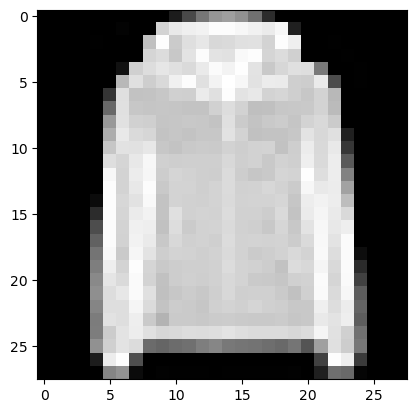

Coat


In [7]:
random_idx = np.random.randint(0, 32)
img = train_features_batch[random_idx].squeeze()
label = train_labels_batch[random_idx]
plt.imshow(img, cmap='gray')
plt.show()
print(classes[label])

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [9]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.2f} seconds")

In [10]:
def training_loop(model,
                  loss_fn,
                  optimizer,
                  epochs,
                  accuracy_fn,
                  trainDataLoader,
                  device):

    train_loss = []
    train_accuracy = []

    model.to(device)  # Ensure the model is on the correct device

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()  # Set the model to training mode
        training_loss = 0
        training_accuracy = 0

        for batch, (X, y) in enumerate(trainDataLoader, start=1):
            # Move data and target to device
            X, y = X.to(device), y.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)
            
            # Compute loss
            loss = loss_fn(y_pred, y)
            training_loss += loss.item()
            
            # Compute accuracy
            training_accuracy += accuracy_fn(y, y_pred.argmax(dim=1))
            
            # Backward pass
            loss.backward()
            optimizer.step()

            if batch % 400 == 0:
                print(f"Done with {batch} batches")

        # Calculate average loss and accuracy for the epoch
        training_loss /= len(trainDataLoader)
        training_accuracy /= len(trainDataLoader)

        # Store loss and accuracy
        train_loss.append(training_loss)
        train_accuracy.append(training_accuracy)

        print(f"Epoch {epoch+1} Training Loss: {training_loss:.4f} | Training Accuracy: {training_accuracy:.2f}")
    
    return train_loss, train_accuracy


In [11]:
def testing_loop(model,
                 testDataLoader,
                 loss_fn,
                 accuracy_fn,
                 device
                 ):
    
    model.to(device)
    model.eval()

    with torch.inference_mode():
        testing_loss = 0
        testing_accuracy = 0

        for X, y in testDataLoader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            testing_loss += loss.item()

            testing_accuracy += accuracy_fn(y, y_pred.argmax(1))

        testing_loss /= len(testDataLoader)
        testing_accuracy /= len(testDataLoader)

        print(f"Testing Loss: {testing_loss:.4f} | Testing Accuracy: {testing_accuracy:.2f}%")

In [35]:
class FashionMNISTV1(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(490, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        X = self.conv_block1(x)
        X = self.conv_block2(X)
        return self.classifier(X)

In [36]:
model_1 = FashionMNISTV1(28*28, 128, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [37]:
training_loop(model_1, loss_fn, optimizer, 5, accuracy_fn, trainDataloader, device)

Epoch 1
-------------------------------
Done with 400 batches
Done with 800 batches
Done with 1200 batches
Done with 1600 batches
Epoch 1 Training Loss: 1.7515 | Training Accuracy: 71.03
Epoch 2
-------------------------------
Done with 400 batches
Done with 800 batches
Done with 1200 batches
Done with 1600 batches
Epoch 2 Training Loss: 1.6834 | Training Accuracy: 77.78
Epoch 3
-------------------------------
Done with 400 batches
Done with 800 batches
Done with 1200 batches
Done with 1600 batches
Epoch 3 Training Loss: 1.6422 | Training Accuracy: 81.84
Epoch 4
-------------------------------
Done with 400 batches
Done with 800 batches
Done with 1200 batches
Done with 1600 batches
Epoch 4 Training Loss: 1.6008 | Training Accuracy: 85.98
Epoch 5
-------------------------------
Done with 400 batches
Done with 800 batches
Done with 1200 batches
Done with 1600 batches
Epoch 5 Training Loss: 1.5909 | Training Accuracy: 87.02


([1.7514673261642455,
  1.68337298634847,
  1.6421634976704915,
  1.6007686793645224,
  1.5908552532831828],
 [71.03333333333333,
  77.78166666666667,
  81.84,
  85.97666666666667,
  87.01666666666667])

In [38]:
testing_loop(model_1, testDataLoader, loss_fn, accuracy_fn, device)

Testing Loss: 1.5965 | Testing Accuracy: 86.41%


## Making a Confusion Matrix

In [109]:
import torchmetrics
import mlxtend

In [110]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(num_classes=10, task = "multiclass")

In [111]:
y_preds = []
model_1.eval()
with torch.inference_mode():
    for X, _ in testDataLoader:
        X = X.to(device)
        y_pred = model_1(X)
        y_preds.append(y_pred.argmax(1))

In [112]:
y_preds = torch.cat(y_preds).cpu()

In [113]:
y_true = []
for _, y in testDataLoader:
    y_true.append(y)

y_true = torch.cat(y_true)

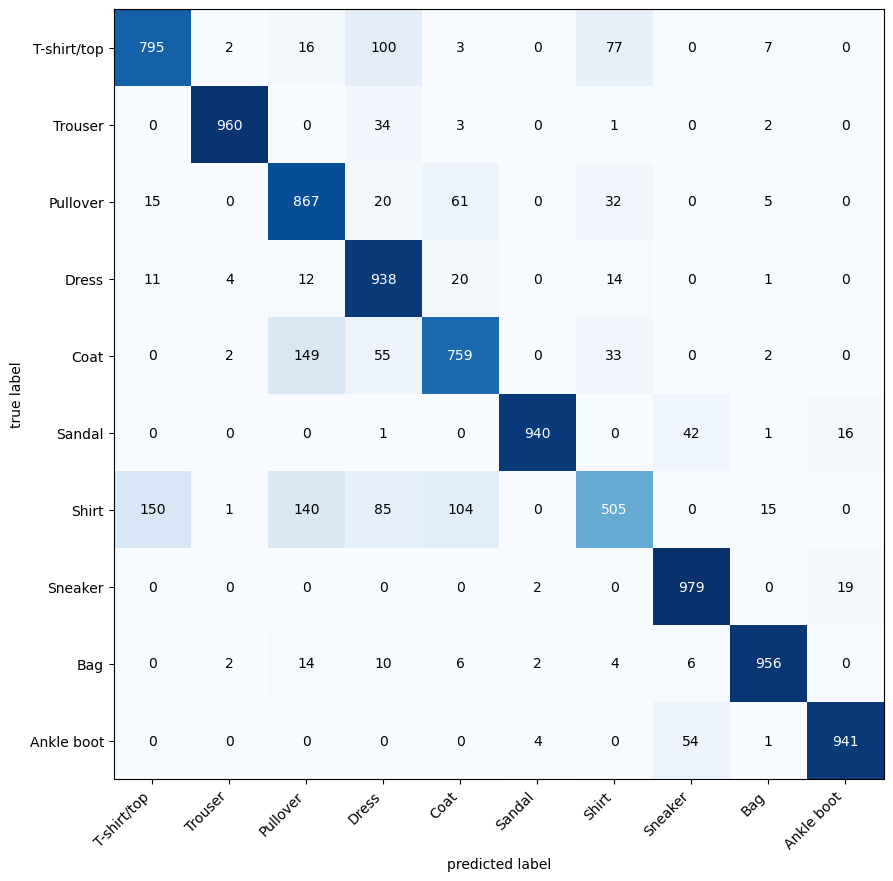

In [116]:
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

conf_matrix = confmat(y_preds, y_true)
fig, ax = plot_confusion_matrix(conf_matrix.numpy(), figsize=(10, 10))
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
plt.show()